In [1]:
from __future__ import annotations

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [2]:
categorical_columns = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]
num_standard_columns = ["age", "trestbps", "chol", "thalach"]
num_min_max_columns = ["oldpeak"]
target_column = "target"
features = categorical_columns + num_standard_columns + num_min_max_columns
columns = [*features, target_column]

# Data Retrieval


In [3]:
# The data is available publicly as a csv file in the UCI ML repository
# 45th is the latest version of the dataset
# It can be downloaded from URL: https://archive.ics.uci.edu/static/public/45/data.csv
# We can load it directly from the URL using pandas

heart_disease_df = pd.read_csv("https://archive.ics.uci.edu/static/public/45/data.csv")

# Preprocessing

## Create Target Column


In [4]:
# num 0 is no heart disease:- 0
# num 1, 2, 3, 4 are heart disease:- 1

heart_disease_df[target_column] = (heart_disease_df["num"] != 0).astype("int8")

## Select Required Columns


In [5]:
heart_disease_df = heart_disease_df[columns]
heart_disease_df.head()

,sex,cp,fbs,restecg,exang,slope,ca,thal,age,trestbps,chol,thalach,oldpeak,target
0,1,1,1,2,0,3,0.0,6.0,63,145,233,150,2.3,0
1,1,4,0,2,1,2,3.0,3.0,67,160,286,108,1.5,1
2,1,4,0,2,1,2,2.0,7.0,67,120,229,129,2.6,1
3,1,3,0,0,0,3,0.0,3.0,37,130,250,187,3.5,0
4,0,2,0,2,0,1,0.0,3.0,41,130,204,172,1.4,0


## One Hot Encoding


In [6]:
# Create an sklearn pipeline for preprocessing and modeling
# First perform one-hot encoding on categorical columns.

train, val_test = train_test_split(
    heart_disease_df,
    test_size=0.3,
    random_state=42,
    stratify=heart_disease_df[target_column],
)

val, test = train_test_split(
    val_test,
    test_size=0.5,
    random_state=42,
    stratify=val_test[target_column],
)

In [7]:
numerical_standard_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ],
)

numerical_min_max_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", MinMaxScaler()),
    ],
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ],
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num_standard", numerical_standard_transformer, num_standard_columns),
        ("num_min_max", numerical_min_max_transformer, num_min_max_columns),
        ("categorical", categorical_transformer, categorical_columns),
    ],
)

In [8]:
def get_best_threshold(
    y_true: np.typing.NDArray[np.int_],
    y_probs: np.typing.NDArray[np.floating],
    min_recall: float = 0.95,
) -> float:
    best_threshold = None
    for threshold in np.linspace(0, 1, 101):
        y_pred_threshold = (y_probs > threshold).astype(int)
        recall = recall_score(y_true, y_pred_threshold, zero_division=0)
        if recall >= min_recall:
            best_threshold = threshold
    return np.round(best_threshold, 4) if best_threshold is not None else 0.0

In [9]:
candidates = {
    "logreg": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "rf": RandomForestClassifier(n_estimators=400, class_weight="balanced"),
    "hgb": HistGradientBoostingClassifier(max_depth=None, learning_rate=0.08),
    "svc": SVC(class_weight="balanced"),
    "gnb": GaussianNB(),
    "xgb": XGBClassifier(
        eval_metric="logloss",
        objective="binary:logistic",
        random_state=42,
        colsample_bytree=0.7,
        gamma=0,
        learning_rate=0.01,
        max_depth=5,
        max_leaves=10,
        min_child_weight=1,
        n_estimators=1000,
        subsample=0.9,
    ),
}

results = []
for name, clf in candidates.items():
    pipe = Pipeline([("prep", preprocessor), ("clf", clf)])
    pipe.fit(train[features], train[target_column])

    yv = (
        pipe.predict_proba(val[features])[:, 1]
        if hasattr(pipe.named_steps["clf"], "predict_proba")
        else pipe.decision_function(val[features])
    )

    best_t = get_best_threshold(val[target_column].to_numpy(), yv, min_recall=0.99)

    yv_pred = (yv >= best_t).astype(int)

    pv = precision_score(val[target_column], yv_pred, zero_division=0)
    rv = recall_score(val[target_column], yv_pred, zero_division=0)
    f1v = f1_score(val[target_column], yv_pred, zero_division=0)
    av = accuracy_score(val[target_column], yv_pred)

    yt = (
        pipe.predict_proba(test[features])[:, 1]
        if hasattr(pipe.named_steps["clf"], "predict_proba")
        else pipe.decision_function(test[features])
    )

    yt_pred = (yt >= best_t).astype(int)
    pt = precision_score(test[target_column], yt_pred, zero_division=0)
    rt = recall_score(test[target_column], yt_pred, zero_division=0)
    f1t = f1_score(test[target_column], yt_pred, zero_division=0)
    at = accuracy_score(test[target_column], yt_pred)

    results.append(
        {
            "name": name,
            "threshold": best_t,
            "recall_val": rv,
            "accuracy_val": av,
            "precision_val": pv,
            "f1_val": f1v,
            "recall_test": rt,
            "accuracy_test": at,
            "precision_test": pt,
            "f1_test": f1t,
        },
    )

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(
    by=["recall_test", "accuracy_test"], ascending=False
).reset_index(drop=True)
results_df

,name,threshold,recall_val,accuracy_val,precision_val,f1_val,recall_test,accuracy_test,precision_test,f1_test
0,rf,0.21,1.000000,0.755556,0.656250,0.792453,1.000000,0.760870,0.656250,0.792453
1,logreg,0.17,1.000000,0.777778,0.677419,0.807692,1.000000,0.739130,0.636364,0.777778
2,xgb,0.09,1.000000,0.733333,0.636364,0.777778,1.000000,0.739130,0.636364,0.777778
3,gnb,0.00,1.000000,0.466667,0.466667,0.636364,1.000000,0.456522,0.456522,0.626866
4,hgb,0.13,1.000000,0.800000,0.700000,0.823529,0.952381,0.760870,0.666667,0.784314
5,svc,0.00,0.714286,0.733333,0.714286,0.714286,0.904762,0.869565,0.826087,0.863636


In [10]:
model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "classifier",
            LogisticRegression(
                solver="liblinear", max_iter=1000, random_state=42, verbose=100
            ),
        ),
    ],
)

model.fit(train[features], train[target_column])

[LibLinear]

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num_standard', ...), ('num_min_max', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of th

In [11]:
threshold = get_best_threshold(
    val[target_column].to_numpy(),
    model.predict_proba(val[features])[:, 1],
    min_recall=0.95,
)
threshold

np.float64(0.18)

In [12]:
y_pred = model.predict_proba(test[features])[:, 1] > threshold
y_true = test[target_column].to_numpy()

In [13]:
# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.7174
Precision: 0.6250
Recall: 0.9524
F1 Score: 0.7547


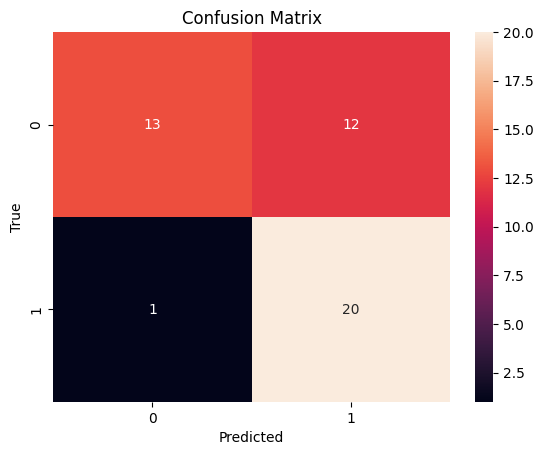

In [14]:
cm = confusion_matrix(y_true, y_pred)

plt.title("Confusion Matrix")

sns.heatmap(data=cm, annot=True, fmt="d")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("../doc/images/heart_disease_confusion_matrix.png")
plt.show()